# Prophet 시계열 예측
---

In [278]:
import pandas as pd
import prophet

## [1] 데이터 로딩
---

In [279]:
# input data 로딩
data_tomato = pd.read_csv("./data/data_tomato.csv", index_col=0)
data_rv = pd.read_csv("./data/data_rv.csv", index_col=0)
data_qva = pd.read_csv("./data/data_qva_inter.csv", index_col=0)

# 합치고 날짜 컬럼 추가
data = pd.concat([data_tomato, data_rv, data_qva], axis=1)
data.reset_index(inplace=True)
data["DATE"] = pd.to_datetime(data["DATE"])

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 34 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   DATE                300 non-null    datetime64[ns]
 1   TCL_AT              300 non-null    float64       
 2   TCL_LT              300 non-null    float64       
 3   TCL_HT              300 non-null    float64       
 4   TEMP_EF_CAP         300 non-null    float64       
 5   TEMP_EF_DONGNAM     300 non-null    float64       
 6   TEMP_EF_DAEGYUNG    300 non-null    float64       
 7   TEMP_EF_CHOONG      300 non-null    float64       
 8   TEMP_EF_HONAM       300 non-null    float64       
 9   TEMP_EF_MEAN        300 non-null    float64       
 10  POWER_WATER         300 non-null    int64         
 11  POWER_FIRE          300 non-null    int64         
 12  POWER_NUCLEAR       300 non-null    int64         
 13  POWER_NAEYEON       300 non-null    int64         

In [280]:
# target 데이터 로딩
target = pd.read_csv("./data/target.csv", index_col=0)
target.reset_index(inplace=True, drop=True)

target_ind = target["IND"]

In [281]:
# data, target 합치기
data_full = pd.concat([data, target], axis=1)
data_full.columns

Index(['DATE', 'TCL_AT', 'TCL_LT', 'TCL_HT', 'TEMP_EF_CAP', 'TEMP_EF_DONGNAM',
       'TEMP_EF_DAEGYUNG', 'TEMP_EF_CHOONG', 'TEMP_EF_HONAM', 'TEMP_EF_MEAN',
       'POWER_WATER', 'POWER_FIRE', 'POWER_NUCLEAR', 'POWER_NAEYEON',
       'POWER_GROUP', 'POWER_TRANS', 'POWER_GAS', 'POWER_JUNG', 'POWER_MOO',
       'POWER_YOU', 'POWER_LNG', 'ELEC_ALL', 'ELEC_FAMILY', 'ELEC_PUBLIC',
       'ELEC_SERVICE', 'ELEC_CIVIL_SUM', 'ELEC_ARGRI_FISHING', 'ELEC_MINING',
       'ELEC_MANUFACT', 'ELEC_INDSUM', 'RV', 'GAS_PRICE_IND', 'OIL_PRICE',
       'QVA', 'CIVIL', 'IND'],
      dtype='object')

In [282]:
# ind 컬럼 정리
ind_cols = ['DATE', 'IND', 'POWER_GAS', 'ELEC_INDSUM', 'RV', 'QVA']

# 최종 데이터 추출
data_final = data_full.loc[:, ind_cols]
data_final.head()

,DATE,IND,POWER_GAS,ELEC_INDSUM,RV,QVA
0,1996-01-01,83809,8408979,9236808,0.97,36550.300000
1,1996-02-01,70427,7593086,8465308,0.93,36751.000000
2,1996-03-01,62652,8306941,9677322,0.96,36951.700000
3,1996-04-01,47050,8299351,9650845,0.94,37152.400000
4,1996-05-01,30709,8156027,9658045,0.92,37365.733333


## [2] prophet 모델
---

In [356]:
def prophet_model(data:pd.DataFrame, col:str, params:dict, periods:int):
    """시계열 예측 결과값 반환해주는 모델
    Args:
        data: 데이터프레임
        col: 피쳐 컬럼 이름
        params: prophets 파라미터
        periods: 예측 일수
    
    Returns:
        pd.DataFrame: 예측 피쳐 데이터프레임형태 반환
    """
    data_c = data.copy()
    # rename cols
    data_c = data_c.rename(columns={col: 'y', "DATE": "ds"})
    
    # add params
    m = prophet.Prophet(**params)
    m.add_country_holidays(country_name="KOR")
    
    # fit model
    m.fit(data_c)
    
    # future data
    future = m.make_future_dataframe(periods=periods, freq='MS')
    forecast = m.predict(future)
    
    # plot forecast
    fig = m.plot(forecast)
    a = prophet.plot.add_changepoints_to_plot(fig.gca(), m, forecast)
    
    # plot components
    m.plot_components(forecast)
    
    # return forecast feature
    pred = forecast['trend'].astype(int)[-periods:]
    date = future.iloc[:,0][-periods:]
    result = pd.concat([date, pred], axis=1)
    
    return result


01:32:13 - cmdstanpy - INFO - Chain [1] start processing
01:32:13 - cmdstanpy - INFO - Chain [1] done processing


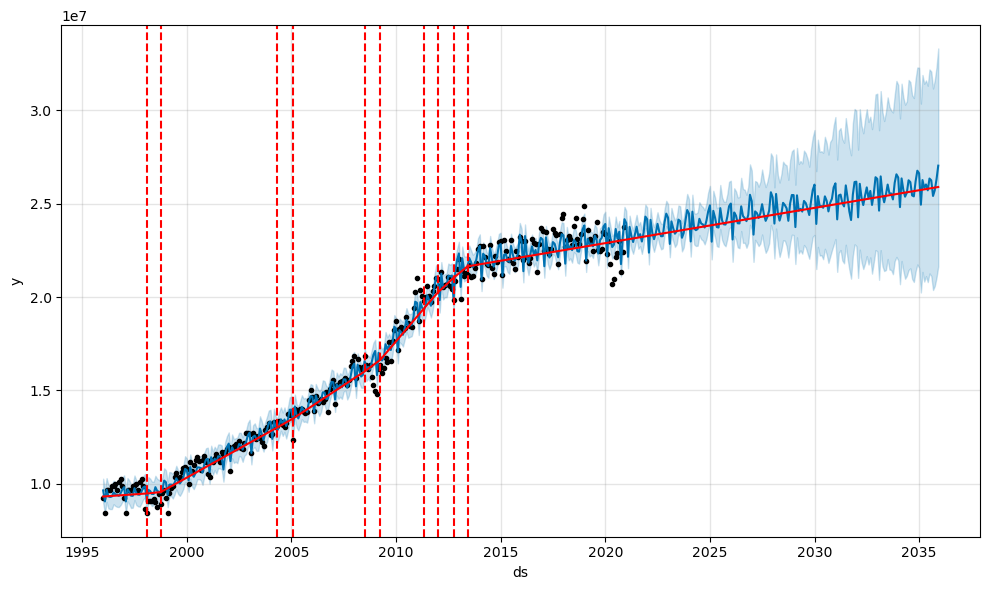

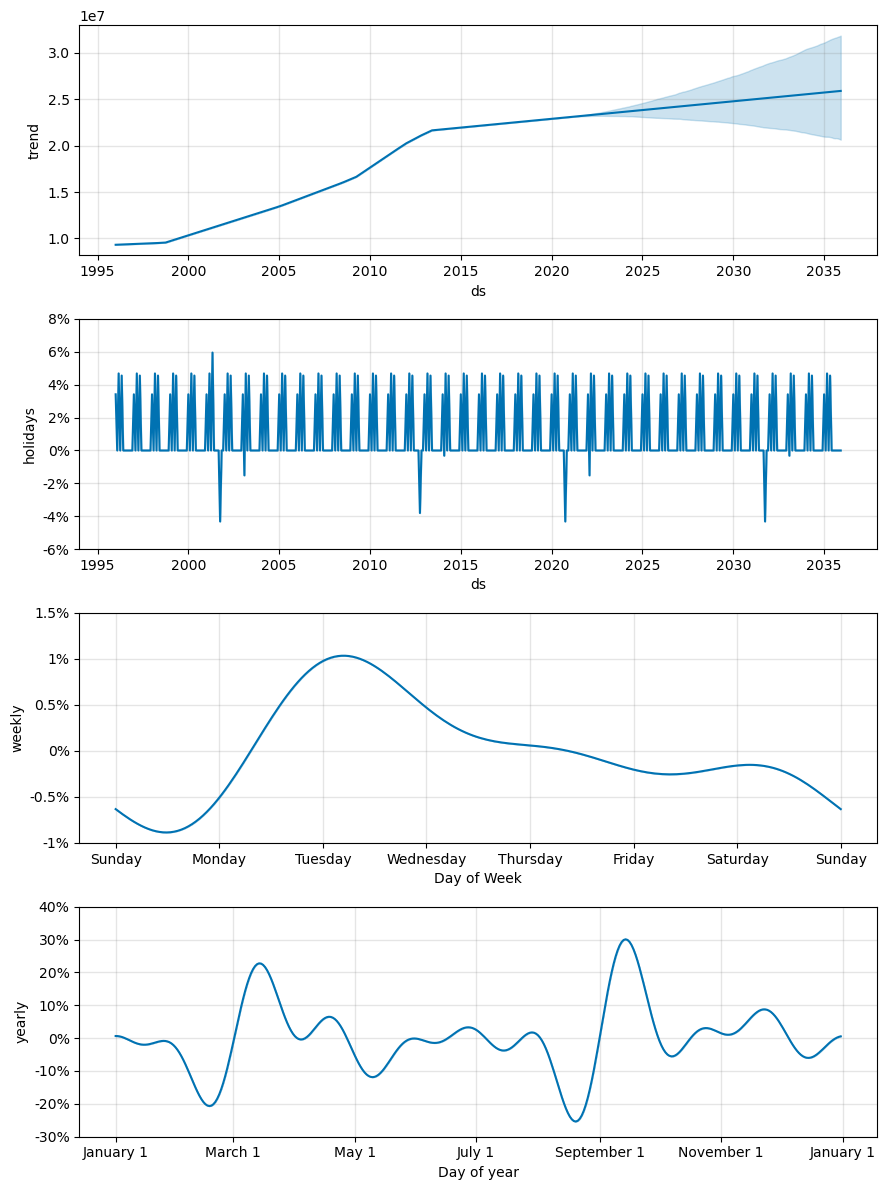

In [357]:
# default scale = 0.05
# default seasonality = 10

params = {
    "changepoint_prior_scale": 0.05,
    "changepoint_range": 0.7,
    "weekly_seasonality": True,
    "yearly_seasonality": True,
    "daily_seasonality": False,
    "seasonality_mode": "multiplicative",
    "holidays_prior_scale": 0.1
}

pred = prophet_model(data_final, 'ELEC_INDSUM', params=params, periods=12*15)

In [358]:
pred

,ds,trend
300,2021-01-01,23074310
301,2021-02-01,23090330
302,2021-03-01,23104799
303,2021-04-01,23120819
304,2021-05-01,23136322
...,...,...
475,2035-08-01,25826079
476,2035-09-01,25842099
477,2035-10-01,25857601
478,2035-11-01,25873621
